In [19]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms, utils
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
from sklearn.preprocessing import scale as standard_scale
from sklearn.model_selection import train_test_split
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
from skorch.dataset import ValidSplit

# torch.manual_seed(0) # Set for our testing purposes, please do not change!

from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor)
from braindecode.preprocessing import \
    create_windows_from_events, create_fixed_length_windows
from braindecode.models import EEGNetv4
from braindecode import EEGClassifier
import mne

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.spatial import distance


# Functions and Classes for EEG DATA

In [2]:
def preprocessor(
    dataset,
    low_cut_hz = 4.,   # low cut frequency for filtering
    high_cut_hz = 38., # high cut frequency for filtering
    newfreq = 100, # Paramater for resampling
    factor = 1e6, # Parameter for scaling
    ):

    preprocessors = [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
        # Preprocessor(lambda data: np.multiply(data, factor)),  # Convert from V to uV
        Preprocessor("resample", sfreq=newfreq), # Resampling
        Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
        Preprocessor("set_eeg_reference", ref_channels="average", ch_type="eeg"), # Common Average Reference
        Preprocessor(standard_scale, channel_wise=True) ## Standard Scale 
    ]

    # Transform the data
    # return preprocess(dataset, preprocessors, n_jobs = -1)
    return preprocess(dataset, preprocessors)

def get_windows(
        dataset, 
        trial_start_offset_samples=0,
        trial_stop_offset_samples=100,
        window_size_samples=400,
        window_stride_samples=100,
        preload=True,
        # mapping = {'left_hand': 0, 'right_hand': 1},
        picks = ['C3', 'Cz', 'C4']
        ):
    
    windows_dataset = create_windows_from_events(
        dataset,
        trial_start_offset_samples = trial_start_offset_samples,
        trial_stop_offset_samples  = trial_stop_offset_samples,
        window_size_samples        = window_size_samples,
        window_stride_samples      = window_stride_samples,
        preload                    = True,
        # mapping = {'left_hand': 0, 'right_hand': 1},
        # picks                      = picks
        )

    # preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)]) ## Standard Scale window
    
    return windows_dataset


def get_tensors_from_windows(windows_dataset):
    windows_list = []
    labels_list = []
    n_runs = len(windows_dataset.datasets)
    for i in range(n_runs):
        windows_list.append(windows_dataset.datasets[i].windows.get_data())
        labels_list.append(windows_dataset.datasets[i].y)
        
    stacked_tensor = np.concatenate(windows_list, axis=0)
    stacked_labels = np.concatenate(labels_list, axis=0)
    
    del windows_list,labels_list
    
    return stacked_tensor, stacked_labels


class EEG(Dataset):

    def __init__(self, subject_id = 3, dataset_name="BNCI2014_001", transform = None):
        
        self.raw_dataset     = MOABBDataset(dataset_name = dataset_name, subject_ids=subject_id)
        self.prepro_dataset  = preprocessor(self.raw_dataset)
        self.windows_dataset = get_windows(self.prepro_dataset)
        self.data            = get_tensors_from_windows(self.windows_dataset)
        self.transform       = transform
        self.classes         = self.windows_dataset.datasets[0].windows.event_id
        
    def __len__(self):
        return self.data[0].shape[0]

        
    def __getitem__(self,idx):
        
        # sample = {'signal': torch.from_numpy(self.data[0])[idx], 'label': torch.from_numpy(self.data[1])[idx]}
        
        sample = (torch.from_numpy(np.expand_dims(self.data[0], axis = 1))[idx], torch.from_numpy(self.data[1])[idx])
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output eeg, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=68, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            #### For 3 channels
            # self.make_gen_block(input_dim, hidden_dim * 4,      kernel_size = (1,60), stride = (1,1)),
            # self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size = (1,60), stride = (1,1)),
            # self.make_gen_block(hidden_dim * 2, hidden_dim,     kernel_size = (1,60), stride = (1,1)),
            # self.make_gen_block(hidden_dim, im_chan,            kernel_size = (3,50), stride = (1,2), padding = (0,2), final_layer=True),
            #### For 22 channels
            self.make_gen_block(input_dim, hidden_dim * 4,      kernel_size = (3,60), stride = (1,1)),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size = (4,60), stride = (3,1)),
            self.make_gen_block(hidden_dim * 2, hidden_dim,     kernel_size = (3,60), stride = (2,1)),
            self.make_gen_block(hidden_dim, im_chan,            kernel_size = (2,50), stride = (1,2), padding = (0,2), final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size, stride, padding = 0, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)


# Classification of the Real Data

In [3]:
## Getting the real data
my_eeg_data = EEG(subject_id=3)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB sto

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 165 samples (1.650 s)

Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']


In [4]:
X = my_eeg_data[:][0].squeeze()
y = my_eeg_data[:][1]

real_complese_dataset =  TensorDataset(X,y)
real_complete_train, real_test = random_split(real_complese_dataset, [0.5,0.5])
real_train, real_eval = random_split(real_complete_train, [0.7,0.3])

def get_train_test_eval(X,y):
    
    complese_dataset     =  TensorDataset(X,y)
    complete_train, test = random_split(real_complese_dataset, [0.5,0.5])
    train, eval          = random_split(real_complete_train, [0.7,0.3])

    return train, test, eval


# Creating Classification Model 

In [5]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'

def train_model(train_dataset, eval_dataset, test_dataset):

    # Classifier Config
    n_epochs = 200
    batch_size = 32
    
    # Parameters configuration - Do not Change!
    # Creating EEGNet model
    model = EEGNetv4(
        in_chans = 22,
        n_classes = 4,
        input_window_samples= 400,
        final_conv_length='auto',
        F1=8,
        D=2,
        F2=8,
        kernel_length=64,
        drop_prob=0.5
    )
    model.to(device)

    # Creating classifier
    EEGNetv4_classifier = EEGClassifier(
        model,
        criterion=torch.nn.NLLLoss,
        optimizer=torch.optim.Adam,
        train_split = predefined_split(eval_dataset),
        # train_split = ValidSplit(0.2),
        batch_size = batch_size,
        callbacks=[
            "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
        ],
        device=device,
    )

    # Trainning
    EEGNetv4_classifier.fit(train_dataset, y=None, epochs=n_epochs)

    # Computing accuracy
    acc = np.mean(EEGNetv4_classifier.predict(test_dataset) == [label for X,label in test_dataset])
    

    return EEGNetv4_classifier,acc

# Loading Weights for Data Generation

In [6]:
## Generator Class
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels of the output eeg, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=68, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            #### For 3 channels
#             self.make_gen_block(input_dim, hidden_dim * 4,      kernel_size = (1,60), stride = (1,1)),
#             self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size = (1,60), stride = (1,1)),
#             self.make_gen_block(hidden_dim * 2, hidden_dim,     kernel_size = (1,60), stride = (1,1)),
#             self.make_gen_block(hidden_dim, im_chan,            kernel_size = (3,50), stride = (1,2), padding = (0,2), final_layer=True),
            #### For 22 channels
            self.make_gen_block(input_dim, hidden_dim * 4,      kernel_size = (3,60), stride = (1,1)),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size = (4,60), stride = (3,1)),
            self.make_gen_block(hidden_dim * 2, hidden_dim,     kernel_size = (3,60), stride = (2,1)),
            self.make_gen_block(hidden_dim, im_chan,            kernel_size = (2,50), stride = (1,2), padding = (0,2), final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size, stride, padding = 0, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)


### Some other functions

In [7]:
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return F.one_hot(labels,n_classes)

def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat((x.float(),y.float()), 1)
    return combined


def generate_samples_with_labels(label, n_samples, generator, z_dim = 64, channel = None, extra_dim = True):
    '''
    Function for generating samples, once the generator has been trained
        label: label of the movement to be sampled. See dictionary below
        {'feet': 0, 'left_hand': 1, 'right_hand': 2, 'tongue': 3}
        n_samples: number of samples to be generated
        channel: electrode {'C3': 0, 'Cz': 1, 'C4': 2} -> Default: All channels
        generator: the trained generator
    '''

    n_classes = 4

    if channel == None:
        noise_4_gen = get_noise(n_samples, z_dim)
        label = get_one_hot_labels(torch.Tensor([label]).long(), n_classes).repeat(n_samples,1)

        noise_and_labels = combine_vectors(noise_4_gen, label)
        fake = generator(noise_and_labels)

        if extra_dim == False:
            fake = fake.reshape((fake.shape[0], fake.shape[2], fake.shape[3]))
        return fake
    else:
        noise_4_gen = get_noise(n_samples, z_dim)
        label = get_one_hot_labels(torch.Tensor([label]).long(), n_classes).repeat(n_samples,1)

        noise_and_labels = combine_vectors(noise_4_gen, label)
        fake = generator(noise_and_labels)
        filtered_channel_fake = torch.select(fake, dim = 2, index = channel)

        if extra_dim == False:
            filtered_channel_fake = filtered_channel_fake.reshape((filtered_channel_fake.shape[0], filtered_channel_fake.shape[2]))

        return filtered_channel_fake


## Loading data

In [8]:
PATH = "../Weights/Conv_Cond_Gan_v4_0.5loss/gen_22ch_batch64_lr37e6_decay7.pt"
gen = Generator()
gen.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Function for Data Augmentation

In [9]:
def generate_samples_for_classification(n_samples, generator):
    '''
    Function for generating equal label samples for the classifier.
        n_samples: number of samples to be generated
        generator: the trained generator
    '''
    n_classes = 4
    z_dim = 64
    
    n_samples_partial = int(n_samples/n_classes)
    noise_4_gen = get_noise(n_samples, z_dim)

    label = [0,1,2,3]

    label = [get_one_hot_labels(torch.Tensor([i]).long(), n_classes).repeat(n_samples_partial,1) for i in label]

    label_concat = torch.zeros_like(torch.Tensor(0,4))
    for i in range(len(label)):
        label_concat = torch.cat((label_concat,label[i]), 0)

    noise_and_labels = combine_vectors(noise_4_gen, label_concat)

    fake = generator(noise_and_labels)

    labels = torch.argmax(label_concat,dim = 1)
    return (fake, labels)


def data_augment(real_dataset, real_labels, augment_percentage, generator):
    '''
    Function for adding fake data into the real data, with percentage "augment_percentage".
    real_dataset: dataset of real data
    real_labels: labels of real data
    augment_percentage: percentage of real data to be added as fake data.
    generator: the trained generator
    '''
    # parameters
    n_classes = 4

    # Get real dataset size
    real_dataset_size = real_dataset.shape[0]
    # Compute size of augmentation
    augment_size = augment_percentage*real_dataset_size
    # If the size is divisible by the number of classes (4) continue, else choose the closest divisible number
    if augment_size % n_classes != 0:
        augment_size = int(augment_size/4.0)
    print("Size of augmentation:",augment_size)

    # Generate fake data
    fake_data, fake_labels = generate_samples_for_classification(augment_size, generator)

    fake_data = fake_data.squeeze()
    
    # Concatenate real and fake data
    augmented_dataset = torch.cat((real_dataset,fake_data), dim = 0)
    augmented_labels  = torch.cat((real_labels,fake_labels), dim = 0)
    print("Final augmented dataset shape:",augmented_dataset.shape)
    
    return augmented_dataset,augmented_labels

### Generate variable augmentations

In [10]:
classification_df = pd.DataFrame(columns = ["Augmentation (%)", "EEGNet Accuracy"] )

augment_percentages = [0,0.07,0.1,0.21,0.53,0.71,1,2]


for count, i in enumerate(augment_percentages):
    print("Augment", i, "%")
    dataset_augmented, labels_augmented = data_augment(X,y,i,gen)
    train_aug, test_aug, eval_aug = get_train_test_eval(dataset_augmented, labels_augmented)
    model, acc = train_model(train_aug, eval_aug, test_aug)
    classification_df.loc[count] = [i*100,acc]

classification_df.to_csv(" classification_results.csv", index = False )

In [11]:
classification_df.to_csv("./Testes_Finais/classification/classification_results.csv", index = False )

In [12]:
classification_df

## JS Metric

In [13]:
def get_hist_from_sample(sample):
    scaler = StandardScaler()
    scaler.fit(sample)
    new_sample = scaler.transform(sample).flatten()
    counts, bins = np.histogram(new_sample, bins = 101, density = True)
    return new_sample, (counts, bins)

def filter_label_and_channel(eeg_data, label, channel):
    '''
    Function to filter label and channel of original eeg data. 
        eeg_data: raw eeg data
        label: class of movement
        channel: electrode --   {'C3': 0, 'Cz': 1, 'C4': 2}
    '''

    mask = torch.where(eeg_data[:][1] == label, 1, 0)
    filtered_eeg = eeg_data[:][0][torch.nonzero(mask).flatten()]
    filtered_eeg = filtered_eeg.reshape((filtered_eeg.shape[0], filtered_eeg.shape[2], filtered_eeg.shape[3] ))
    filtered_channel_eeg = torch.select(filtered_eeg, dim = 1, index = channel)

    return filtered_channel_eeg


def generate_samples_with_labels(label, n_samples, generator, z_dim = 64, channel = None, extra_dim = True):
    '''
    Function for generating samples, once the generator has been trained
        label: label of the movement to be sampled. See dictionary below
        {'feet': 0, 'left_hand': 1, 'right_hand': 2, 'tongue': 3}
        n_samples: number of samples to be generated
        channel: electrode {'C3': 0, 'Cz': 1, 'C4': 2} -> Default: All channels
        generator: the trained generator
    '''
    
    n_classes = 4
    
    if channel == None:
        noise_4_gen = get_noise(n_samples, z_dim)
        label = get_one_hot_labels(torch.Tensor([label]).long(), n_classes).repeat(n_samples,1)
        
        noise_and_labels = combine_vectors(noise_4_gen, label)
        fake = generator(noise_and_labels)

        if extra_dim == False:
            fake = fake.reshape((fake.shape[0], fake.shape[2], fake.shape[3]))
        return fake
    else:
        noise_4_gen = get_noise(n_samples, z_dim)
        label = get_one_hot_labels(torch.Tensor([label]).long(), n_classes).repeat(n_samples,1)
        
        noise_and_labels = combine_vectors(noise_4_gen, label)
        fake = generator(noise_and_labels)
        filtered_channel_fake = torch.select(fake, dim = 2, index = channel)
        
        if extra_dim == False:
            filtered_channel_fake = filtered_channel_fake.reshape((filtered_channel_fake.shape[0], filtered_channel_fake.shape[2]))

        return filtered_channel_fake



In [14]:
my_eeg_data.windows_dataset.datasets[0].windows.to_data_frame().columns

Index(['time', 'condition', 'epoch', 'Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4',
       'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2',
       'CP4', 'P1', 'Pz', 'P2', 'POz'],
      dtype='object')

In [15]:
labels = [0,1,2,3]
label_desc = ['feet','left_hand','right_hand','tongue'] #{'feet': 0, 'left_hand': 1, 'right_hand': 2, 'tongue': 3}
channels = [i for i in range(22)]
channel_desc = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4',
       'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2',
       'CP4', 'P1', 'Pz', 'P2', 'POz']
n_samples = 288

# DF configure
js_df = pd.DataFrame(columns = channel_desc, index = label_desc)

In [16]:
for i in range(len(labels)):
    row_values = []
    for j in range(len(channels)):
        print(i,j)
        label = i
        channel = j

        # print("label", label_desc[label])
        # print("channel", channel_desc[channel])
        ## Real Samples
        real_samples = filter_label_and_channel(eeg_data = my_eeg_data, label = label, channel = channel).detach().numpy()
        ## Fake samples
        gen_samples = generate_samples_with_labels(label = label, n_samples = n_samples, channel = channel, generator = gen, extra_dim = False).detach().numpy()
        
        _,(real_dist,_) = get_hist_from_sample(real_samples)
        _,(fake_dist,_) = get_hist_from_sample(gen_samples)
        
        # Jensen Shannon metric
        #real_data_np = [0][0my_eeg_data].numpy()
        
        #js_pq = distance.jensenshannon(real_data_np, generated_data_np[0], 2.0)
        js_pq = distance.jensenshannon(real_dist, fake_dist, 2.0)
        # js_pq_mean = np.nanmean(js_pq)
        row_values.append(js_pq)
        
        # print('JS(P || Q) Distance (Mean): %.3f' % js_pq)
    
    # Save the data in the dataframe 
    js_df.iloc[i] = row_values

# Save dataframe
js_df.to_csv("./Testes_Finais/classification/JS_Metric.csv", index = True)

In [20]:
js_df = pd.read_csv("./Testes_Finais/classification/JS_Metric.csv", index_col = 0)
js_df = round(js_df,2)
js_df

,Fz,FC3,FC1,FCz,FC2,FC4,C5,C3,C1,Cz,...,C6,CP3,CP1,CPz,CP2,CP4,P1,Pz,P2,POz
feet,0.20,0.88,0.51,0.56,0.31,0.75,0.61,0.89,0.56,0.71,...,0.59,0.94,0.59,0.88,0.50,0.65,0.83,0.76,0.57,0.54
left_hand,0.64,0.94,0.58,0.87,0.41,0.90,0.54,0.83,0.87,0.93,...,0.62,0.94,0.75,0.90,0.63,0.34,0.75,0.86,0.69,0.65
right_hand,0.26,0.91,0.59,0.91,0.37,0.52,0.64,0.91,0.57,0.80,...,0.64,0.91,0.62,0.64,0.82,0.66,0.65,0.77,0.40,0.76
tongue,0.87,0.96,0.55,0.90,0.42,0.74,0.77,0.91,0.60,0.71,...,0.57,0.93,0.63,0.87,0.48,0.54,0.80,0.76,0.57,0.59


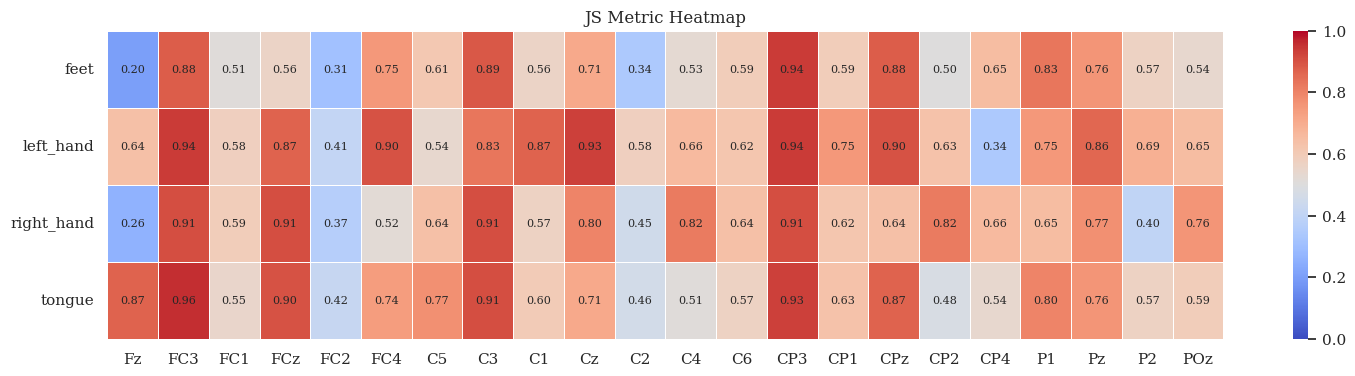

In [21]:
plt.figure(figsize=(18, 4))  # Adjust the figure size as needed
heatmap = sns.heatmap(js_df, cmap='coolwarm', vmin=0.0, vmax=1.0, fmt=".2f", linewidths=.5)
# heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=8)
# heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, ha='right', fontsize=8)

# Show the values in each cell
for i in range(len(js_df)):
    for j in range(len(js_df.columns)):
        plt.text(j + 0.5, i + 0.5, f"{js_df.iloc[i, j]:.2f}", ha='center', va='center', fontsize=8)

plt.title("JS Metric Heatmap")
# Show the plot
plt.savefig("./Testes_Finais/classification/JS_Metric_Heatmap.png")
plt.show()


## Creating histograms


In [22]:
channles_choice = [4,7,9,10,11]
channels_choice_names = ["FC2", "C3", "Cz", "C2", "C4"]
real_sample = my_eeg_data[:][0].numpy().squeeze()[:,channles_choice,:]
fake_sample = generate_samples_for_classification(1152, gen)
fake_sample = fake_sample[0].detach().numpy().squeeze()[:,channles_choice,:]


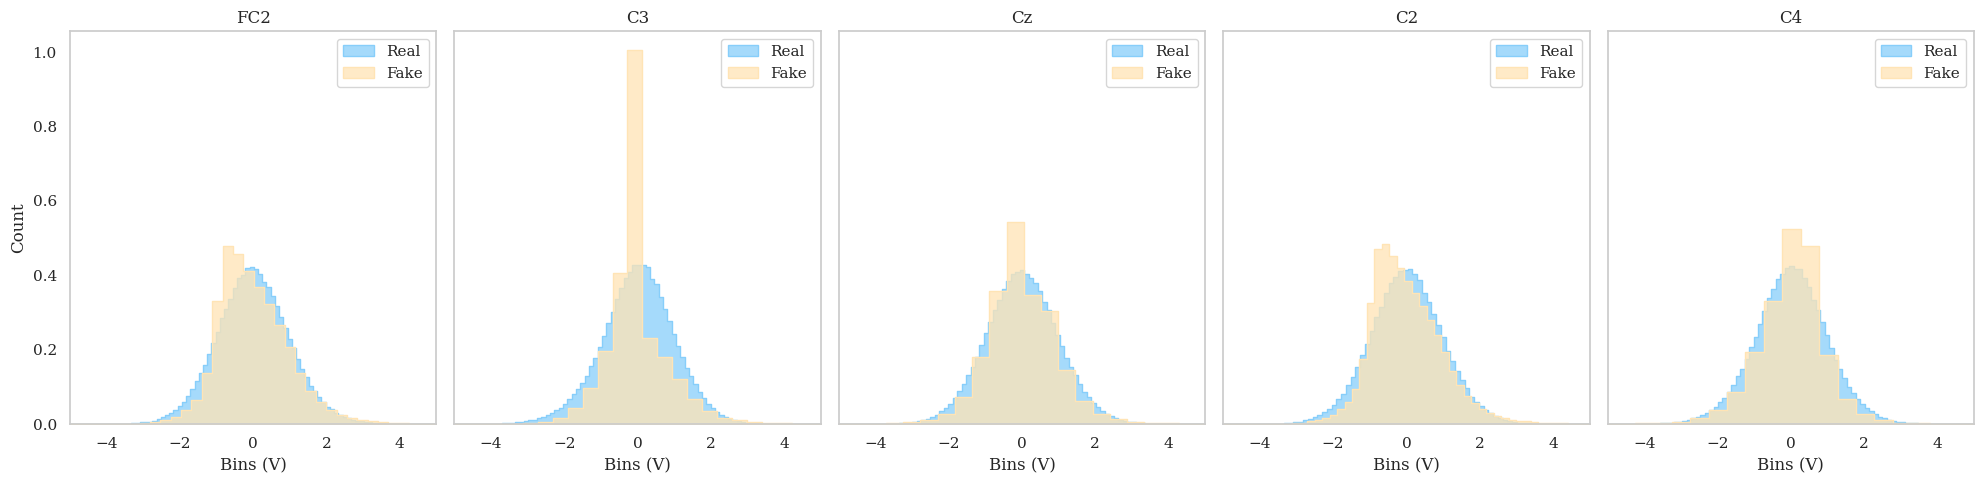

In [23]:
# Create a grid of 1x5 plots
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Loop through each channel
for i, ax in enumerate(axes):

    ith_real_sample = real_sample[:,i,:]
    ith_fake_sample = fake_sample[:,i,:]
    
    scaler_real = StandardScaler()
    scaler_fake = StandardScaler()
    
    scaler_real.fit(ith_real_sample)
    scaler_fake.fit(ith_fake_sample)
    
    ith_real_sample = scaler_real.transform(ith_real_sample)
    ith_fake_sample = scaler_fake.transform(ith_fake_sample)
    
    # Plot real data
    sns.histplot(ith_real_sample.flatten(), bins=101, stat="density", kde=False, color='lightskyblue', element="step", label="Real", ax=ax)

    # Plot fake data
    sns.histplot(ith_fake_sample.flatten(), bins=101, stat="density", kde=False, color='moccasin', element="step", label="Fake", ax=ax)

    # Set labels and title for each subplot
    ax.set_xlabel(r'Bins (V)')
    ax.set_title(f'{channels_choice_names[i]}')
    ax.grid()
    ax.legend()
    ax.set_xlim([-5, 5]) 

# Set common ylabel
axes[0].set_ylabel('Count')

# Adjust layout to prevent clipping of ylabel
plt.tight_layout()
plt.savefig("./Testes_Finais/classification/Real_and_Fake_Histogram_Comparison.png")
# Show the plot
plt.show()